In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.manifold import TSNE
from joblib import parallel_backend
from project_functions.modeling import run_model
from project_functions.utils import picklify, unpickle
import pickle

/home/josh/.local/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
# df = pd.read_parquet('../data/cleaned/tokenized_data_large_genres.parquet')

In [2]:
# X_train_count_unigrams = unpickle('../data/cleaned/train/X_train_count_unigrams.pickle')
# X_test_count_unigrams = unpickle('../data/cleaned/test/X_test_count_unigrams.pickle')
# X_train_count_bigrams = unpickle('../data/cleaned/train/X_train_count_bigrams.pickle')
# X_test_count_bigrams = unpickle('../data/cleaned/test/X_test_count_bigrams.pickle')
# X_train_gensim_2gram_sparse = unpickle('../data/cleaned/train/X_train_gensim_2gram_sparse.pickle').T
# X_test_gensim_2gram_sparse = unpickle('../data/cleaned/test/X_test_gensim_2gram_sparse.pickle').T
# X_train_gensim_3gram_sparse = unpickle('../data/cleaned/train/X_train_gensim_3gram_sparse.pickle').T
# X_test_gensim_3gram_sparse = unpickle('../data/cleaned/test/X_test_gensim_3gram_sparse.pickle').T
# X_train_gensim_4gram_sparse = unpickle('../data/cleaned/train/X_train_gensim_4gram_sparse.pickle').T
# X_test_gensim_4gram_sparse = unpickle('../data/cleaned/test/X_test_gensim_4gram_sparse.pickle').T
X_train_glove = unpickle('../data/cleaned/train/X_train_glove.pickle')
X_test_glove = unpickle('../data/cleaned/test/X_test_glove.pickle')
X_train_word2vec = unpickle('../data/cleaned/train/X_train_word2vec.pickle')
X_test_word2vec = unpickle('../data/cleaned/test/X_test_word2vec.pickle')
y_train = unpickle('../data/cleaned/train/y_train.pickle')
y_test = unpickle('../data/cleaned/test/y_test.pickle')

In [4]:
# mnb_count_unigrams = run_model(X_train_count_unigrams, X_test_count_unigrams, y_train, y_test,
#                              MultinomialNB(), plot_confusion = True, display_report = True,
#                              pickle_ = True, pickle_dest = '../data/models/mnb_count_unigrams.pickle')

In [5]:
# mnb_count_bigrams = run_model(X_train_count_bigrams, X_test_count_bigrams, y_train, y_test,
#                              MultinomialNB(), plot_confusion = True, display_report = True,
#                              pickle_ = True, pickle_dest = '../data/models/mnb_count_bigrams.pickle')

In [6]:
# mnb_gensim_2gram = run_model(X_train_gensim_2gram_sparse, X_test_gensim_2gram_sparse, y_train, y_test,
#                              MultinomialNB(), plot_confusion = True, display_report = True,
#                              pickle_ = True, pickle_dest = '../data/models/mnb_gensim_2gram.pickle')

In [7]:
# mnb_gensim_3gram = run_model(X_train_gensim_3gram_sparse, X_test_gensim_3gram_sparse, y_train, y_test,
#                              MultinomialNB(), plot_confusion = True, display_report = True,
#                              pickle_ = True, pickle_dest = '../data/models/mnb_gensim_3gram.pickle')

In [8]:
# mnb_gensim_4gram = run_model(X_train_gensim_4gram_sparse, X_test_gensim_4gram_sparse, y_train, y_test,
#                              MultinomialNB(), plot_confusion = True, display_report = True,
#                              pickle_ = True, pickle_dest = '../data/models/mnb_gensim_4gram.pickle')

Score: 0.49478005865102637
              precision    recall  f1-score   support

           0       0.31      0.41      0.35       911
           1       0.55      0.48      0.51       639
           2       0.70      0.71      0.70       840
           3       0.50      0.51      0.51      1014
           4       0.47      0.37      0.41       601
           5       0.53      0.61      0.57       969
           6       0.26      0.21      0.23       896
           7       0.79      0.51      0.62       690
           8       0.64      0.71      0.67       917
           9       0.39      0.40      0.39      1048

    accuracy                           0.49      8525
   macro avg       0.51      0.49      0.50      8525
weighted avg       0.50      0.49      0.49      8525



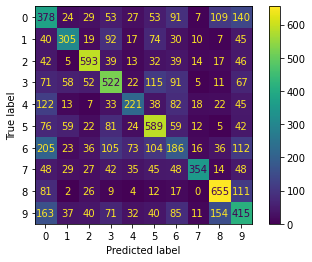

In [4]:
# baseline_xg_gensim_2gram = run_model(X_train_gensim_2gram_sparse, X_test_gensim_2gram_sparse, y_train, y_test,
#                              XGBClassifier(), plot_confusion = True, display_report = True,
#                              pickle_ = True, pickle_dest = '../data/models/baseline_xg_gensim_2gram.pickle')

Score: 0.4946627565982405
              precision    recall  f1-score   support

           0       0.30      0.41      0.35       911
           1       0.56      0.49      0.52       639
           2       0.70      0.72      0.71       840
           3       0.48      0.50      0.49      1014
           4       0.47      0.37      0.42       601
           5       0.54      0.61      0.57       969
           6       0.26      0.20      0.23       896
           7       0.78      0.52      0.62       690
           8       0.64      0.72      0.68       917
           9       0.38      0.39      0.39      1048

    accuracy                           0.49      8525
   macro avg       0.51      0.49      0.50      8525
weighted avg       0.50      0.49      0.49      8525



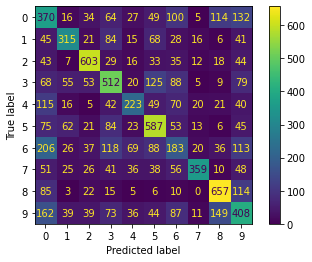

In [5]:
# baseline_xg_gensim_3gram = run_model(X_train_gensim_3gram_sparse, X_test_gensim_3gram_sparse, y_train, y_test,
#                              XGBClassifier(), plot_confusion = True, display_report = True,
#                              pickle_ = True, pickle_dest = '../data/models/baseline_xg_gensim_3gram.pickle')

Score: 0.49853372434017595
              precision    recall  f1-score   support

           0       0.30      0.42      0.35       911
           1       0.55      0.49      0.52       639
           2       0.72      0.70      0.71       840
           3       0.49      0.51      0.50      1014
           4       0.48      0.38      0.42       601
           5       0.56      0.61      0.58       969
           6       0.27      0.22      0.25       896
           7       0.79      0.53      0.64       690
           8       0.63      0.72      0.67       917
           9       0.38      0.38      0.38      1048

    accuracy                           0.50      8525
   macro avg       0.52      0.50      0.50      8525
weighted avg       0.51      0.50      0.50      8525



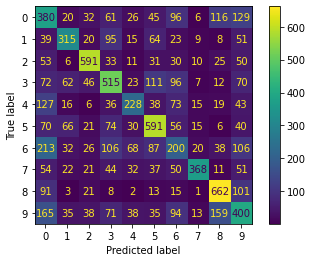

In [6]:
# baseline_xg_gensim_4gram = run_model(X_train_gensim_4gram_sparse, X_test_gensim_4gram_sparse, y_train, y_test,
#                              XGBClassifier(), plot_confusion = True, display_report = True,
#                              pickle_ = True, pickle_dest = '../data/models/baseline_xg_gensim_4gram.pickle')

/home/joshua/anaconda3/envs/learn-env/lib/python3.8/site-packages/xgboost/data.py:173: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


Score: 0.46791788856304983
              precision    recall  f1-score   support

           0       0.29      0.29      0.29       911
           1       0.51      0.40      0.45       639
           2       0.68      0.64      0.66       840
           3       0.41      0.51      0.46      1014
           4       0.47      0.38      0.42       601
           5       0.56      0.58      0.57       969
           6       0.25      0.25      0.25       896
           7       0.64      0.47      0.54       690
           8       0.68      0.71      0.69       917
           9       0.35      0.41      0.38      1048

    accuracy                           0.47      8525
   macro avg       0.48      0.46      0.47      8525
weighted avg       0.48      0.47      0.47      8525



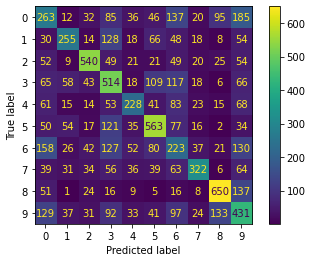

In [7]:
# baseline_xg_glove = run_model(X_train_glove, X_test_glove, y_train, y_test,
#                              XGBClassifier(), plot_confusion = True, display_report = True,
#                              pickle_ = True, pickle_dest = '../data/models/baseline_xg_glove.pickle')

Score: 0.4656891495601173
              precision    recall  f1-score   support

           0       0.30      0.31      0.30       911
           1       0.50      0.41      0.45       639
           2       0.70      0.62      0.66       840
           3       0.42      0.50      0.45      1014
           4       0.49      0.39      0.43       601
           5       0.55      0.57      0.56       969
           6       0.23      0.24      0.23       896
           7       0.65      0.48      0.55       690
           8       0.67      0.71      0.69       917
           9       0.35      0.41      0.38      1048

    accuracy                           0.47      8525
   macro avg       0.49      0.46      0.47      8525
weighted avg       0.48      0.47      0.47      8525



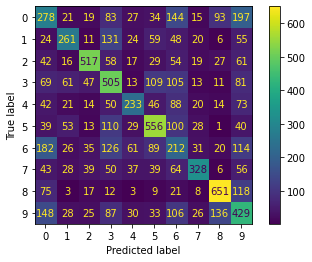

In [8]:
# baseline_xg_word2vec = run_model(X_train_word2vec, X_test_word2vec, y_train, y_test,
#                              XGBClassifier(), plot_confusion = True, display_report = True,
#                              pickle_ = True, pickle_dest = '../data/models/baseline_xg_word2vec.pickle')

In [9]:
# params = {
#     'n_estimators': 1000,
#     'max_depth': 3,
#     'min_child_weight': 1,
#     'subsample':1,
#     'colsample_bytree':1,
#     'alpha': 1,
#     'gamma': 0.1
# }

# pickle_dest = '../data/models/best_xg_gensim_2gram.pickle'

# best_xg_gensim_2gram = run_model(X_train_gensim_2gram_sparse, X_test_gensim_2gram_sparse, y_train, y_test,
#                                         XGBClassifier(), model_params = params, display_report = True,
#                                         pickle_ = True, pickle_dest = pickle_dest)

Score: 0.5229325513196481
              precision    recall  f1-score   support

           0       0.33      0.42      0.37       911
           1       0.57      0.50      0.53       639
           2       0.75      0.73      0.74       840
           3       0.52      0.55      0.53      1014
           4       0.48      0.45      0.46       601
           5       0.57      0.64      0.60       969
           6       0.28      0.24      0.26       896
           7       0.73      0.58      0.65       690
           8       0.68      0.73      0.70       917
           9       0.42      0.40      0.41      1048

    accuracy                           0.52      8525
   macro avg       0.53      0.52      0.53      8525
weighted avg       0.53      0.52      0.52      8525



In [10]:
# params = {
#     'n_estimators': 1000,
#     'max_depth': 3,
#     'min_child_weight': 1,
#     'subsample':1,
#     'colsample_bytree':1,
#     'alpha': 1,
#     'gamma': 0.1
# }

# pickle_dest = '../data/models/best_xg_gensim_3gram.pickle'

# best_xg_gensim_3gram = run_model(X_train_gensim_3gram_sparse, X_test_gensim_3gram_sparse, y_train, y_test,
#                                         XGBClassifier(), model_params = params, display_report = True,
#                                         pickle_ = True, pickle_dest = pickle_dest)

Score: 0.524574780058651
              precision    recall  f1-score   support

           0       0.33      0.41      0.37       911
           1       0.57      0.51      0.54       639
           2       0.75      0.73      0.74       840
           3       0.52      0.54      0.53      1014
           4       0.47      0.45      0.46       601
           5       0.59      0.64      0.61       969
           6       0.28      0.24      0.26       896
           7       0.76      0.58      0.65       690
           8       0.68      0.73      0.70       917
           9       0.42      0.42      0.42      1048

    accuracy                           0.52      8525
   macro avg       0.54      0.52      0.53      8525
weighted avg       0.53      0.52      0.52      8525



In [11]:
# params = {
#     'n_estimators': 1000,
#     'max_depth': 3,
#     'min_child_weight': 1,
#     'subsample':1,
#     'colsample_bytree':1,
#     'alpha': 1,
#     'gamma': 0.1
# }

# pickle_dest = '../data/models/best_xg_gensim_4gram.pickle'

# best_xg_gensim_4gram = run_model(X_train_gensim_4gram_sparse, X_test_gensim_4gram_sparse, y_train, y_test,
#                                         XGBClassifier(), model_params = params, display_report = True,
#                                         pickle_ = True, pickle_dest = pickle_dest)

Score: 0.5260997067448681
              precision    recall  f1-score   support

           0       0.33      0.41      0.37       911
           1       0.57      0.50      0.53       639
           2       0.76      0.73      0.74       840
           3       0.53      0.55      0.54      1014
           4       0.48      0.44      0.46       601
           5       0.59      0.63      0.61       969
           6       0.28      0.25      0.27       896
           7       0.74      0.59      0.65       690
           8       0.68      0.74      0.71       917
           9       0.43      0.42      0.43      1048

    accuracy                           0.53      8525
   macro avg       0.54      0.53      0.53      8525
weighted avg       0.53      0.53      0.53      8525



In [3]:
params = {
    'n_estimators': 500,
    'max_depth': 3,
    'min_child_weight': 1,
    'subsample': 1,
    'colsample_bytree':1,
    'alpha': 1,
    'gamma': 0.1
}

pickle_dest = '../data/models/best_xg_glove.pickle'

best_xg_glove = run_model(X_train_glove, X_test_glove, y_train, y_test,
                                        XGBClassifier(), model_params = params,
#                           display_report = True,
                                        pickle_ = True, pickle_dest = pickle_dest)

/home/josh/.local/lib/python3.8/site-packages/xgboost/data.py:173: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [4]:
params = {
    'n_estimators': 500,
    'max_depth': 3,
    'min_child_weight': 1,
    'subsample':1,
    'colsample_bytree':1,
    'alpha': 1,
    'gamma': 0.1
}

pickle_dest = '../data/models/best_xg_word2vec.pickle'

best_xg_word2vec = run_model(X_train_word2vec, X_test_word2vec, y_train, y_test,
                                        XGBClassifier(), model_params = params,
#                              display_report = True,
                                        pickle_ = True, pickle_dest = pickle_dest)

In [19]:
# # %%timeit
# # Tuning max depth and min child weight
# params = {
#     'n_estimators': [1000],
#     'max_depth': [3, 6, 9],
#     'min_child_weight': [1, 3, 5],
#     'subsample': [0.8],
#     'colsample_bytree': [0.8],
#     'alpha': [1],
#     'gamma': [0]
# }

# pickle_dest = '../data/models/max_depth_min_child_xgboost_gensim_2gram.pickle'

# xg_gridsearch_gensim = run_model(X_train_gensim_sparse, X_test_gensim_sparse, y_train, y_test,
#                                         XGBClassifier(), grid_search = True, scoring = None,
#                                         model_params = params, plot_confusion = True, display_report = True,
#                                         pickle_ = True, pickle_dest = pickle_dest)

In [20]:
# # %%timeit
# # Tuning gamma
# params = {
#     'n_estimators': [1000],
#     'max_depth': [3],
#     'min_child_weight': [1],
#     'subsample': [0.8],
#     'colsample_bytree': [0.8],
#     'alpha': [1],
#     'gamma': [i / 10.0 for i in range(0, 6)]
# }

# pickle_dest = '../data/models/gamma_xgboost_gensim_2gram.pickle'

# xg_gridsearch_gensim = run_model(X_train_gensim_sparse, X_test_gensim_sparse, y_train, y_test,
#                                         XGBClassifier(), grid_search = True, scoring = None,
#                                         model_params = params, display_report = True,
#                                         pickle_ = True, pickle_dest = pickle_dest)

In [21]:
# # %%timeit
# # Tuning subsampling
# params = {
#     'n_estimators': [1000],
#     'max_depth': [3],
#     'min_child_weight': [1],
#     'subsample':[i/10.0 for i in range(6,10)],
#     'colsample_bytree':[i/10.0 for i in range(6,10)],
#     'alpha': [1],
#     'gamma': [0.1]
# }

# pickle_dest = '../data/models/subsample_colsample_xgboost_gensim_2gram.pickle'

# xg_gridsearch_gensim = run_model(X_train_gensim_sparse, X_test_gensim_sparse, y_train, y_test,
#                                         XGBClassifier(), grid_search = True, scoring = None,
#                                         model_params = params, display_report = True,
#                                         pickle_ = True, pickle_dest = pickle_dest)

In [22]:
# # %%timeit
# # Tuning subsampling further
# params = {
#     'n_estimators': [1000],
#     'max_depth': [3],
#     'min_child_weight': [1],
#     'subsample':[0.9, 0.95, 1],
#     'colsample_bytree':[0.9, 0.95, 1],
#     'alpha': [1],
#     'gamma': [0.1]
# }

# pickle_dest = '../data/models/subsample_colsample_higher_xgboost_gensim_2gram.pickle'

# xg_gridsearch_gensim = run_model(X_train_gensim_sparse, X_test_gensim_sparse, y_train, y_test,
#                                         XGBClassifier(), grid_search = True, scoring = None,
#                                         model_params = params, display_report = True,
#                                         pickle_ = True, pickle_dest = pickle_dest)

In [23]:
# # %%timeit
# # Best Params
# params = {
#     'n_estimators': [1000],
#     'max_depth': [3],
#     'min_child_weight': [1],
#     'subsample':[1],
#     'colsample_bytree':[1],
#     'alpha': [1],
#     'gamma': [0.1]
# }

# pickle_dest = '../data/models/subsample_colsample_higher_xgboost_gensim_2gram.pickle'

# xg_gridsearch_gensim = run_model(X_train_gensim_sparse, X_test_gensim_sparse, y_train, y_test,
#                                         XGBClassifier(), grid_search = True, scoring = None,
#                                         model_params = params, display_report = True,
#                                         pickle_ = True, pickle_dest = pickle_dest)